# [E-04] Awesome lyricist

> 목차
-


**1. 개요**  
    
    1.1 프로젝트 과정 및 목표  
    1.2 예상되는 문제점  
    1.3 용어  

**2. 루브릭 평가기준**  

**3. Project**
    
    3.1 데이터 준비하기    
    3.2 데이터 전처리  
    3.3 데이터 분리 및 학습시키기  
    3.4 데이터 테스트
**4. 회고**
    
    4.1 결과 평가  
    4.2 어려웠던 점
    4.3 참조
    

---
> **1. 개요**
-

> **1.1 프로젝트 과정 및 목표**

프로젝트의 과정은   
1. 데이터 준비  
2. 데이터 전처리
3. 데이터 분리 및 학습시키기
4. 데이터 테스트
의 과정으로 이뤄진다.

목표는 자연스러운 말이 출력이 되는걸로 우선적으로 잡았습니다.

> **1.2 예상되는 문제점**

+ NLP를 처음으로 접해서 코드를 이해하는데 어려움이 있을 것 같다.
+ 학습하는데 걸리는 시간이 길어서 프로젝트 시간이 길어질 수 있다.

> **1.3 용어**

+ **순환 신경망(RNN)**
: 시계열 데이터와 같이 시간의 흐름에 따라 변화하는 데이터를 학습하기 위한 인공 신경망
+ **언어모델(Language Model)**
: n−1개의 단어 시퀀스가 주어졌을 때, n번째 단어 w으로 무엇이 올지를 예측하는 확률 모델  
+ **토큰화(Tokenization)**
: 자연어 처리에서 크롤링 등으로 얻어낸 코퍼스 데이터가 필요에 맞게 전처리되지 않은 상태라면, 해당 데이터를 사용하고자하는 용도에 맞게 토큰화(tokenization) & 정제(cleaning) & 정규화(normalization)하는 일을 하게 됩니다. 이번에는 그 중에서도 토큰화에 대해서 학습합니다.  
주어진 코퍼스(corpus)에서 토큰(token)이라 불리는 단위로 나누는 작업을 토큰화(tokenization)라고 합니다.
+ **소스문장(Source Sentence)**
: 모델의 입력이 되는 문장
+ **타겟문장(Target Sentence)**
: 모델의 출력 문장
+ **텐서(Tensor)**
: 텐서란 매우 수학적인 개념으로 데이터의 배열이라고 볼 수 있습니다. 텐서의 Rank는 간단히 말해서 몇 차원 배열인가를 의미

---
> **2. 루브릭 평가기준**
-

|평가문항 | 상세기준|
|:---------|:---------|
|1.가사 텍스트 생성 모델이 정상적으로 동작하는가? | 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?|
|2.데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가? | 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?|
|3.텍스트 생성모델이 안정적으로 학습되었는가?| 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?|

---
> **3. Project**
-

> 3.1 데이터 준비하기

In [1]:
import glob # 파일 읽어오기가 용이함
import os, re
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


> 3.2 데이터 전처리

In [2]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 15: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Now I've heard there was a secret chord
That David played, and it pleased the Lord
But you don't really care for music, do you?
It goes like this
The fourth, the fifth
The minor fall, the major lift
The baffled king composing Hallelujah Hallelujah
Hallelujah
Hallelujah
Hallelujah Your faith was strong but you needed proof
You saw her bathing on the roof
Her beauty and the moonlight overthrew her
She tied you
To a kitchen chair
She broke your throne, and she cut your hair
And from your lips she drew the Hallelujah Hallelujah


In [3]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    tmp = preprocess_sentence(sentence)
    if len(tmp.split()) > 15: continue
    corpus.append(tmp)
    
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

In [4]:
# 토큰화 
import keras
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post',maxlen = 15)  
    
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2967 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  118 ...    0    0    0]
 [   2  258  194 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fbe44359a90>


In [5]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 15: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it
12 : me
13 : my
14 : in
15 : that


In [6]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

> 3.3 데이터 분리 및 학습시키기

In [7]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                    tgt_input, 
                                                    test_size=0.2, # 전체의 20프로를 테스트 데이터로 사용함을 의미
                                                    random_state=32) # 랜덤성을 결정

In [8]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)


> 3.4 데이터 테스트

In [9]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [10]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 512 # 워드 벡터의 차원수 단어가 추상적으로 표현되는 크기
hidden_size = 2048 # 모델에 얼마나 많은 일꾼을 둘것인가?
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [11]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-3.09162890e-04,  2.44220835e-04, -1.60413358e-04, ...,
          2.63404305e-04, -3.50302253e-06, -2.67830183e-04],
        [-4.45797807e-04,  5.43098897e-04, -2.60865083e-04, ...,
          4.16130089e-04,  3.76105279e-04, -3.94352188e-04],
        [-5.39327273e-04,  4.22886660e-04,  2.55806499e-05, ...,
          2.74052087e-04,  2.85774120e-04, -4.18458192e-04],
        ...,
        [ 3.18504218e-03,  2.59923586e-03, -3.83088039e-03, ...,
          7.61765870e-04, -2.38400674e-03,  1.69440333e-04],
        [ 3.55065032e-03,  2.85611395e-03, -4.59420495e-03, ...,
          8.45399220e-04, -2.73591117e-03,  3.21258587e-04],
        [ 3.84523254e-03,  3.03917797e-03, -5.28183999e-03, ...,
          8.85773217e-04, -3.03919264e-03,  4.34380054e-04]],

       [[-3.09162890e-04,  2.44220835e-04, -1.60413358e-04, ...,
          2.63404305e-04, -3.50302253e-06, -2.67830183e-04],
        [-6.18144870e-04, -7.49558676e-05, -1

In [12]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset,
                                      epochs=10,
                                      batch_size=256,
                                      validation_data=(enc_val, dec_val))

Epoch 1/10
487/487 [==============================] - 255s 515ms/step - loss: 3.3164 - val_loss: 2.9475
Epoch 2/10
487/487 [==============================] - 259s 532ms/step - loss: 2.7831 - val_loss: 2.7033
Epoch 3/10
487/487 [==============================] - 279s 572ms/step - loss: 2.4944 - val_loss: 2.5253
Epoch 4/10
487/487 [==============================] - 260s 534ms/step - loss: 2.2104 - val_loss: 2.3879
Epoch 5/10
487/487 [==============================] - 260s 534ms/step - loss: 1.9363 - val_loss: 2.2845
Epoch 6/10
487/487 [==============================] - 260s 533ms/step - loss: 1.6839 - val_loss: 2.2074
Epoch 7/10
487/487 [==============================] - 260s 533ms/step - loss: 1.4648 - val_loss: 2.1621
Epoch 8/10
487/487 [==============================] - 260s 534ms/step - loss: 1.2872 - val_loss: 2.1410
Epoch 9/10
487/487 [==============================] - 260s 533ms/step - loss: 1.1525 - val_loss: 2.1469
Epoch 10/10
487/487 [==============================] - 260s 533m

In [22]:
# 평가하기
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

generate_text(model, tokenizer, init_sentence="<start> i love", max_len=15)

'<start> i love you , i love you <end> '

> **4. 회고**
-

> 4.1 결과 평가

i love you, i love you 라는 엄청 로맨틱한 글이 나와서 기분이 굉장히 좋았습니다.   
+ val_loss를 낮추는 과정을 좀 더 세밀하게 여러번 시도했었는데 그래서 결과가 좋게 나왔다고 생각합니다.  
+ 데이터의 전처리가 잘되서 모델이 잘 나왔다고 생각합니다.  


> 4.2 어려웠던 점

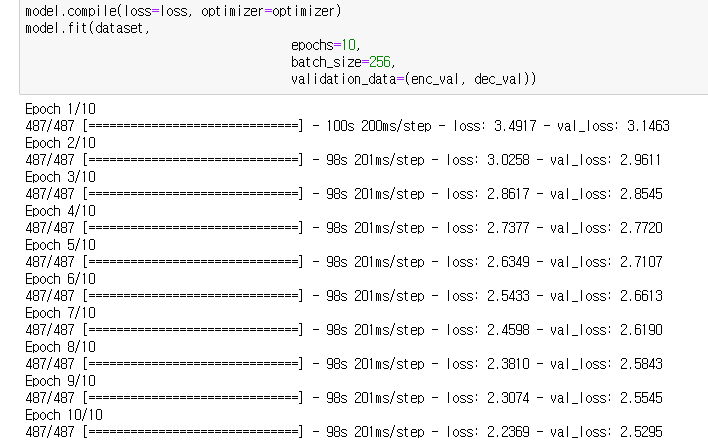


val_loss를 2.2 이하로 맞추기 위해서   
+ embedding_size     
+ hidden_size   

하이퍼 파라미터를 각각 512, 2048로 조정한 결과 2.16 까지 떨어뜨릴 수 있었습니다.  
값들을 증가시킬때마다 시간이 엄청 길어지지만 서서히 val_loss가 감소함을 알 수 있었습니다.  

> 4.3  참조

Val_loss 를 구하기 위해 참조 했습니다.  
https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ko